# 04 - MSM analysis

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

In this notebook, we will cover how to analyze an MSM and how the modeled processes correspond to MSM spectral properties.
We assume that you are familiar with data loading/visualization
([Notebook 01 ➜ 📓](01-data-io-and-featurization.ipynb)),
dimension reduction ([Notebook 02 ➜ 📓](02-dimension-reduction-and-discretization.ipynb)), and
the estimation and validation process ([Notebook 03 ➜ 📓](03-msm-estimation-and-validation.ipynb)).

Maintainers: [@cwehmeyer](https://github.com/cwehmeyer), [@marscher](https://github.com/marscher), [@thempel](https://github.com/thempel), [@psolsson](https://github.com/psolsson)

**Remember**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;
- you can find the full documentation at [PyEMMA.org](http://www.pyemma.org).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mdshare
import pyemma

## Case 1: preprocessed, two-dimensional data (toy model)
We load the two-dimensional trajectory from an archive using numpy,
directly discretize the full space using $k$-means clustering,
visualize the marginal and joint distributions of both components as well as the cluster centers,
and show the implied timescale (ITS) convergence:

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|                       | 0/50 [00:00<?, ?it/s]

kmeans iterations:   0%|                                 | 0/50 [00:00<?, ?it/s]

26-02-25 14:19:15 pyemma.coordinates.clustering.kmeans.KmeansClustering[0] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
/home/cadeniran/.local/lib/python3.11/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


estimating BayesianMSM:   0%|                             | 0/6 [00:00<?, ?it/s]

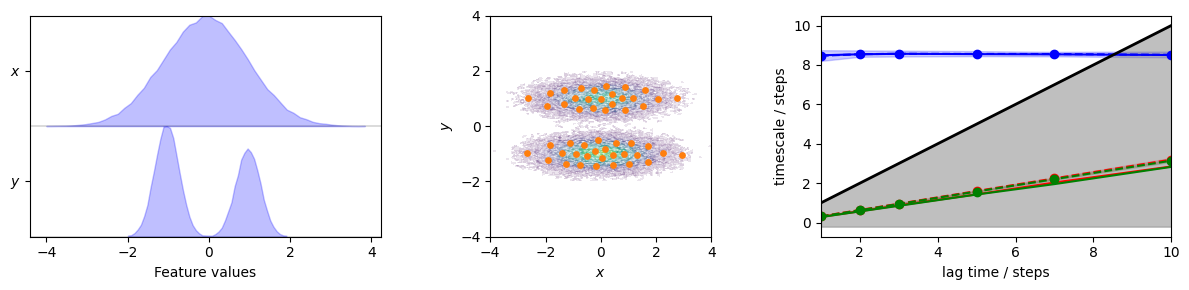

In [2]:
file = mdshare.fetch('hmm-doublewell-2d-100k.npz', working_directory='data')
with np.load(file) as fh:
    data = fh['trajectory']

cluster = pyemma.coordinates.cluster_kmeans(data, k=50, max_iter=50)
its = pyemma.msm.its(
    cluster.dtrajs, lags=[1, 2, 3, 5, 7, 10], nits=3, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(data, feature_labels=['$x$', '$y$'], ax=axes[0])
pyemma.plots.plot_density(*data.T, ax=axes[1], cbar=False, alpha=0.1)
axes[1].scatter(*cluster.clustercenters.T, s=15, c='C1')
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].set_aspect('equal')
pyemma.plots.plot_implied_timescales(its, ylog=False, ax=axes[2])
fig.tight_layout()

The plots show us the marginal (left panel) and joint distributions along with the cluster centers (middle panel).
The implied timescales are converged (right panel). 

Before we proceed, let's have a look at the implied timescales error bars.
They were computed from a Bayesian MSM, as requested by the `errors='bayes'` argument of the `pyemma.msm.its()` function.
As mentioned before, Bayesian MSMs incorporate a sample of transition matrices.
Target properties such as implied timescales can now simply be computed from the individual matrices.
Thereby, the posterior distributions of these properties can be estimated.
The ITS plot shows a confidence interval that contains $95\%$ of the Bayesian samples.

In [3]:
bayesian_msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=1, conf=0.95)

pyemma.msm.estimators.bayesian_msm.BayesianMSM[4]: Sampling MSMs:   0%| | 0/100 

For any PyEMMA method that derives target properties from MSMs, sample mean and confidence intervals (as defined by the function argument above) are directly accessible with  `sample_mean()` and `sample_conf()`.
Further, `sample_std()` is available for computing the standard deviation.
In the more general case, it might be interesting to extract the full sample of a function evaluation with `sample_f()`.
The syntax is equivalent for all those functions.

In [4]:
sample_mean = bayesian_msm.sample_mean('timescales', k=1)
sample_conf_l, sample_conf_r = bayesian_msm.sample_conf('timescales', k=1)

print('Mean of first ITS: {:f}'.format(sample_mean[0]))
print('Confidence interval: [{:f}, {:f}]'.format(sample_conf_l[0], sample_conf_r[0]))

Mean of first ITS: 8.504733
Confidence interval: [8.242713, 8.793076]


Please note that sample mean and maximum likelihood estimates are not identical and generally do not provide numerically identical results.

Now, for the sake of simplicity we proceed with the analysis of a maximum likelihood MSM.
We estimate it at lag time $1$ step...

In [5]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=1)

... and check for disconnectivity.
The MSM is constructed on the largest set of discrete states that are (reversibly) connected.
The `active_state_fraction` and `active_count_fraction` show us the fraction of discrete states and transition counts from our data which are part of this largest set and, thus, used for the model:

In [6]:
print('fraction of states used = {:f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:f}'.format(msm.active_count_fraction))

fraction of states used = 1.000000
fraction of counts used = 1.000000


The fraction is, in both cases, $1$ and, thus, we have no disconnected states (which we would have to exclude from our analysis).

If there were any disconnectivities in our data (fractions $<1$),
we could access the indices of the **active states** (members of the largest connected set) via the `active_set` attribute:

In [7]:
print(msm.active_set)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


With this potential issue out of the way, we can extract our first (stationary/thermodynamic) property,
the `stationary_distribution` or, as a shortcut, `pi`:

In [8]:
print(msm.stationary_distribution)
print('sum of weights = {:f}'.format(msm.pi.sum()))

[0.02397024 0.0214602  0.00943011 0.01186012 0.01835023 0.02316019
 0.03094031 0.03377031 0.02463027 0.00764006 0.01452012 0.03225032
 0.01695017 0.01660016 0.01503014 0.03508034 0.03329039 0.01983021
 0.01685018 0.01504016 0.01378014 0.02385024 0.02389025 0.01315011
 0.00355004 0.01586016 0.00432004 0.01251013 0.03324031 0.02181023
 0.03331034 0.02298023 0.01908021 0.0201302  0.01647016 0.00607007
 0.01780017 0.01649016 0.01941019 0.02286023 0.02764032 0.03135022
 0.0111301  0.0331203  0.01829018 0.02671028 0.01667016 0.01599018
 0.0241203  0.0137601 ]
sum of weights = 1.000000


The attribute `msm.pi` tells us, for each discrete state, the absolute probability of observing said state in global equilibrium.
Mathematically speaking, the stationary distribution $\pi$ is the left eigenvector of the transition matrix $\mathbf{P}$ to the eigenvalue $1$:

$$\pi^\top \mathbf{P} = \pi^\top.$$

Please note that the $\pi$ is fundamentaly different from a normalized histogram of states:
for the histogram of states to accurately describe the stationary distribution, the data needs to be sampled from global equilibrium, i.e, the data points need to be statistically independent.
The MSM approach, on the other hand, only requires local equilibrium, i.e., statistical independence of state transitions.
Thus, the MSM approach requires a much weaker and, in practice, much easier to satisfy condition than simply counting state visits.

We can use the stationary distribution to, e.g., visualize the weight of the dicrete states and, thus, to highlight which areas of our feature space are most probable.
Here, we show all data points in a two dimensional scatter plot and color/weight them according to their discrete state membership:

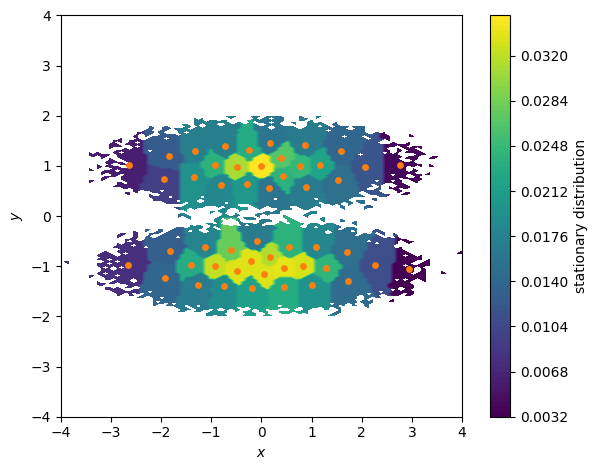

In [9]:
fig, ax, misc = pyemma.plots.plot_contour(
    *data.T, msm.pi[cluster.dtrajs[0]],
    cbar_label='stationary distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.clustercenters.T, s=15, c='C1')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_aspect('equal')
fig.tight_layout()

The stationary distribution can also be used to correct the `pyemma.plots.plot_free_energy()` function that we used to visualize this dataset in [Notebook 01 ➜ 📓](01-data-io-and-featurization.ipynb).
This might be necessary if the data points are not sampled from global equilibrium.

In this case, we assign the weight of the corresponding discrete state to each data point and pass this information to the plotting function via its `weights` parameter:

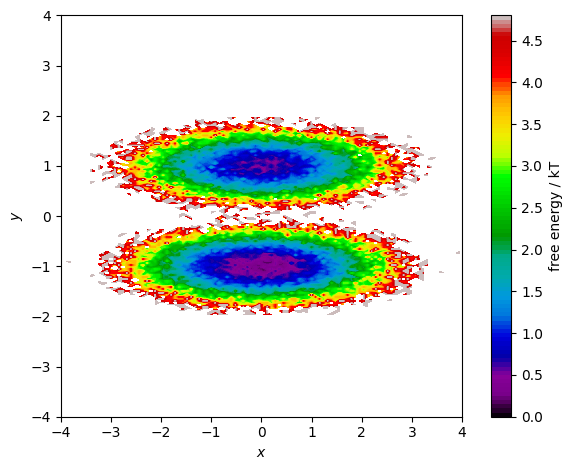

In [10]:
fig, ax, misc = pyemma.plots.plot_free_energy(
    *data.T,
    weights=np.concatenate(msm.trajectory_weights()),
    legacy=False)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_aspect('equal')
fig.tight_layout()

We will see further uses of the stationary distribution later.
But for now, we continue the analysis of our model by visualizing its (right) eigenvectors which encode the dynamical processes.
First, we notice that the first right eigenvector is a constant $1$.

In [11]:
eigvec = msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

first eigenvector is one: True (min=0.9999999999999957, max=1.000000000000006)


Second, the higher eigenvectors can be visualized as follows:

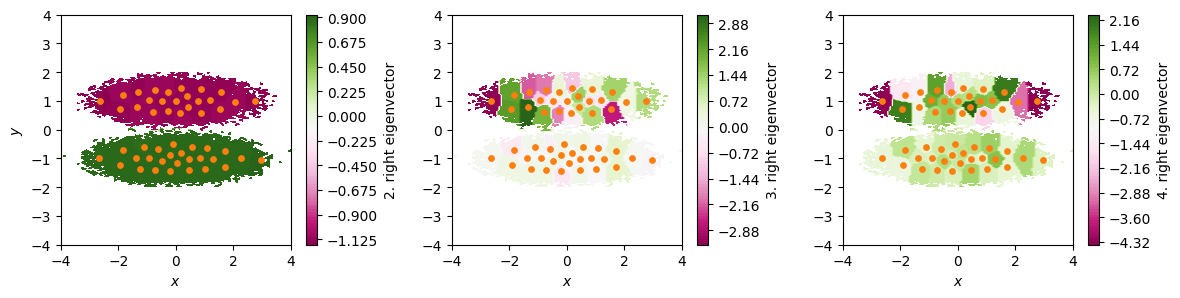

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *data.T, eigvec[cluster.dtrajs[0], i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*cluster.clustercenters.T, s=15, c='C1')
    ax.set_xlabel('$x$')
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_aspect('equal')
axes[0].set_ylabel('$y$')
fig.tight_layout()

The right eigenvectors can be used to visualize the processes governed by the corresponding implied timescales.
The first right eigenvector (always) is $(1,\dots,1)^\top$ for an MSM transition matrix and it corresponds to the stationary process (infinite implied timescale).

The second right eigenvector corresponds to the slowest process;
its entries are negative for one group of discrete states and positive for the other group.
This tells us that the slowest process happens between these two groups and that the process relaxes on the slowest ITS ($\approx 8.5$ steps).

The third and fourth eigenvectors show a larger spread of values and no clear grouping.
In combination with the ITS convergence plot, we can safely assume that these eigenvectors contain just noise and do not indicate any resolved processes.

We then continue to validate our MSM with a CK test for $2$ metastable states which are already indicated by the second right eigenvector.

estimating MaximumLikelihoodMSM:   0%|                    | 0/9 [00:00<?, ?it/s]

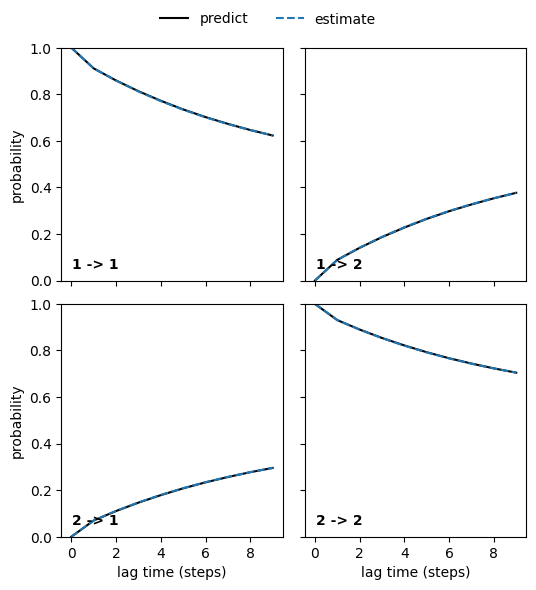

In [13]:
nstates = 2
pyemma.plots.plot_cktest(msm.cktest(nstates));

We now save the model to do more analyses with PCCA++ and TPT in [Notebook 05 ➜ 📓](05-pcca-tpt.ipynb):

In [14]:
cluster.save('nb4.pyemma', model_name='doublewell_cluster', overwrite=True)
msm.save('nb4.pyemma', model_name='doublewell_msm', overwrite=True)
bayesian_msm.save('nb4.pyemma', model_name='doublewell_bayesian_msm', overwrite=True)

/opt/Python-3.11.10/lib/python3.11/site-packages/pyemma/_base/serialization/pickle_extensions.py:58: UserWarning: BLOSC compression filter unavailable. Your resulting file may be large and not optimal to process.
  warnings.warn('BLOSC compression filter unavailable. '


## Case 2: low-dimensional molecular dynamics data (alanine dipeptide)

We fetch the alanine dipeptide data set, load the backbone torsions into memory,
directly discretize the full space using $k$-means clustering,
visualize the margial and joint distributions of both components as well as the cluster centers,
and show the ITS convergence to help selecting a suitable lag time:

Obtaining file info:   0%|                                | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                    | 0/3 [00:00<?, ?it/s]

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|                      | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                 | 0/50 [00:00<?, ?it/s]

26-02-25 14:19:34 pyemma.coordinates.clustering.kmeans.KmeansClustering[9] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
/home/cadeniran/.local/lib/python3.11/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


getting output of KmeansClustering:   0%|                 | 0/3 [00:00<?, ?it/s]

estimating BayesianMSM:   0%|                             | 0/6 [00:00<?, ?it/s]

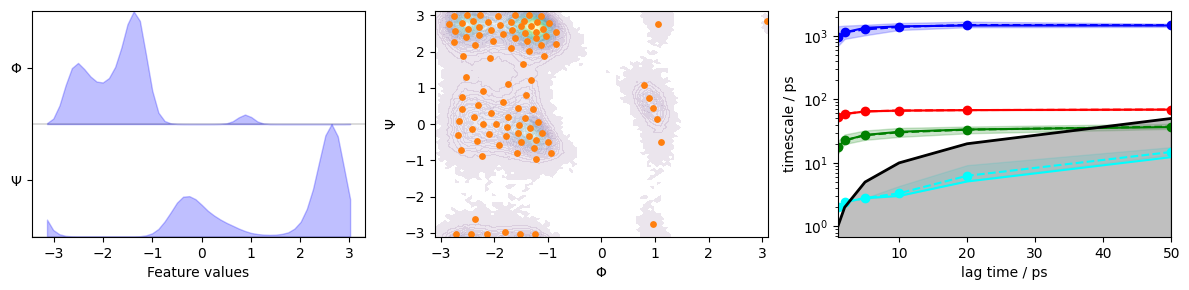

In [15]:
pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='data')

feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

cluster = pyemma.coordinates.cluster_kmeans(data, k=100, max_iter=50, stride=10)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

its = pyemma.msm.its(
    cluster.dtrajs, lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(
    np.concatenate(data), feature_labels=['$\Phi$', '$\Psi$'], ax=axes[0])
pyemma.plots.plot_density(*data_concatenated.T, ax=axes[1], cbar=False, alpha=0.1)
axes[1].scatter(*cluster.clustercenters.T, s=15, c='C1')
axes[1].set_xlabel('$\Phi$')
axes[1].set_ylabel('$\Psi$')
pyemma.plots.plot_implied_timescales(its, ax=axes[2], units='ps')
fig.tight_layout()

The plots show us the marginal (left panel) and joint distributions along with the cluster centers (middle panel).
The implied timescales are converged (right panel). 

We then estimate an MSM at lag time $10$ ps and visualize the stationary distribution by coloring all data points according to the stationary weight of the discrete state they belong to:

fraction of states used = 1.000000
fraction of counts used = 1.000000


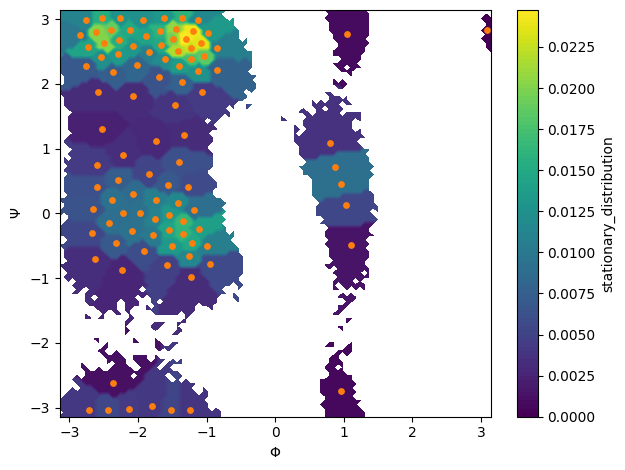

In [16]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=10, dt_traj='1 ps')

print('fraction of states used = {:f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:f}'.format(msm.active_count_fraction))

fig, ax, misc = pyemma.plots.plot_contour(
    *data_concatenated.T, msm.pi[dtrajs_concatenated],
    cbar_label='stationary_distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.clustercenters.T, s=15, c='C1')
ax.set_xlabel('$\Phi$')
ax.set_ylabel('$\Psi$')
fig.tight_layout()

Next, we visualize the first six right eigenvectors:

first eigenvector is one: True (min=0.9999999999999936, max=1.0000000000001066)


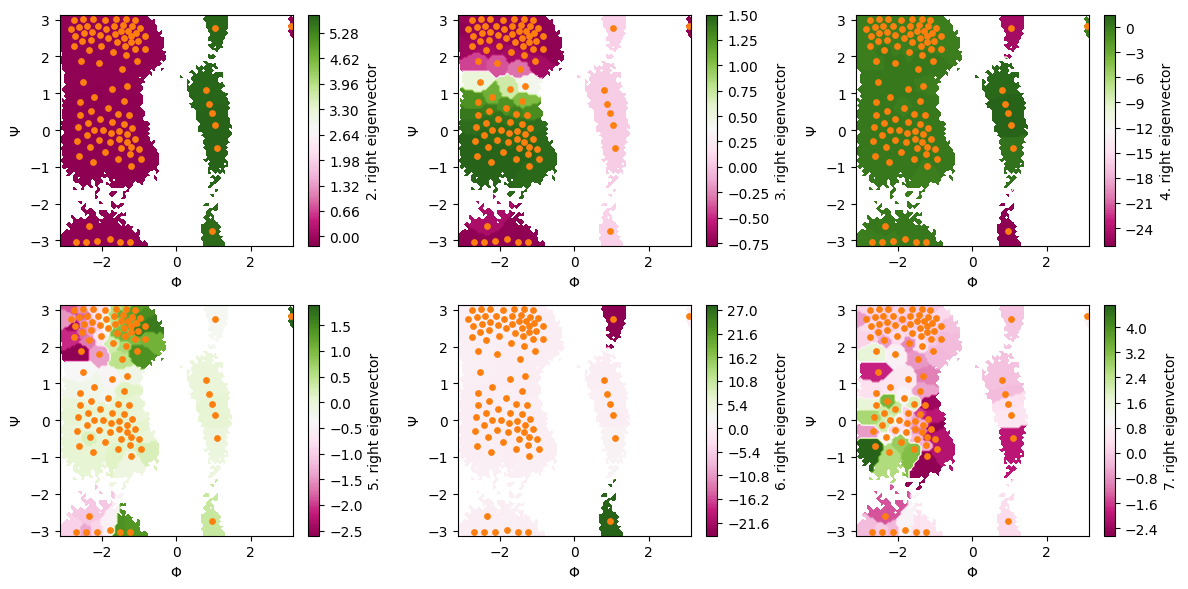

In [17]:
eigvec = msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *data_concatenated.T, eigvec[dtrajs_concatenated, i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*cluster.clustercenters.T, s=15, c='C1')
    ax.set_xlabel('$\Phi$')
    ax.set_ylabel('$\Psi$')
fig.tight_layout()

Again, we have the $(1,\dots,1)^\top$ first right eigenvector of the stationary process.

The second to fourth right eigenvectors illustrate the three slowest processes which are (in that order):

- rotation of the $\Phi$ dihedral,
- rotation of the $\Psi$ dihedral when $\Phi\approx-2$ rad, and
- rotation of the $\Psi$ dihedral when $\Phi\approx1$ rad.

Eigenvectors five, six, and seven indicate further processes which, however, relax faster than the lag time and cannot be resolved clearly.

We now proceed our validation process using a Bayesian MSM with four metastable states:

pyemma.msm.estimators.bayesian_msm.BayesianMSM[14]: Sampling MSMs:   0%| | 0/100

estimating BayesianMSM:   0%|                             | 0/9 [00:00<?, ?it/s]

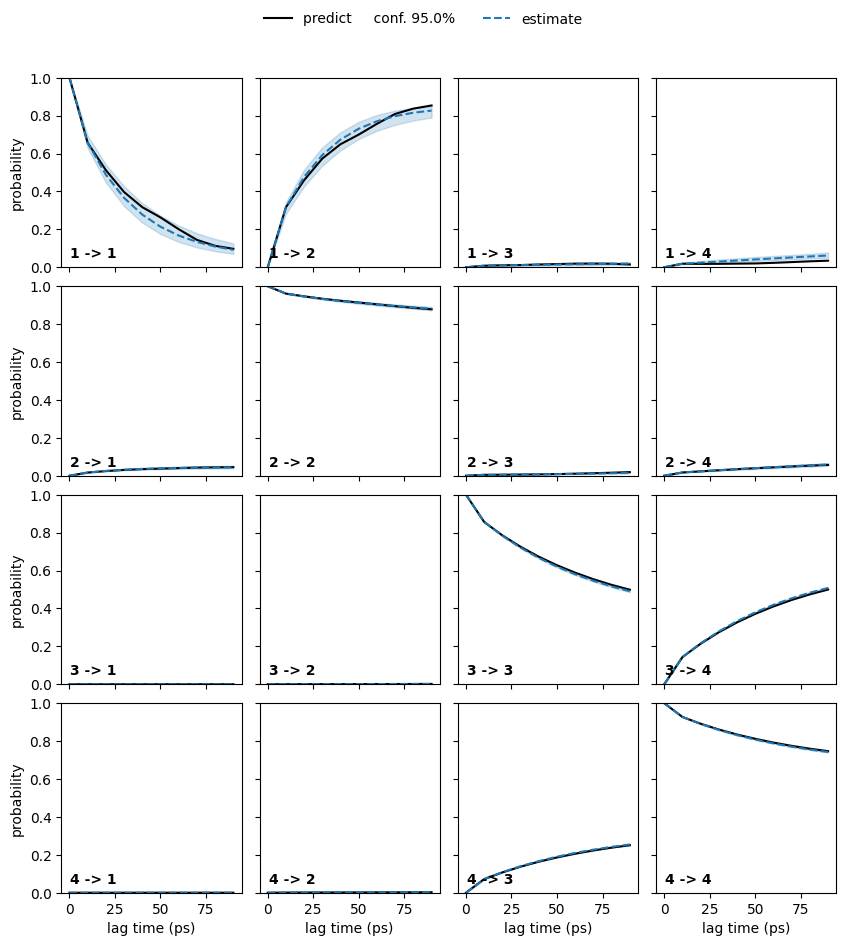

In [18]:
nstates = 4
bayesian_msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=10, dt_traj='1 ps')
pyemma.plots.plot_cktest(bayesian_msm.cktest(nstates), units='ps');

We note that four metastable states are a reasonable choice for our MSM.

In general, the number of metastable states is a modeler's choice; it is adjusted to map the kinetics to be modeled.
In the current example, increasing the resolution with a higher number of metastable states or resolving only the slowest process between $2$ states would be possible.
However, the number of states is not arbitrary as the observed processes in metastable state space need not be Markovian in general.
A failed Chapman-Kolmogorov test can thus also hint to a bad choice of the metastable state number.

In order to perform further analysis, we save the model to disk:

In [19]:
cluster.save('nb4.pyemma', model_name='ala2_cluster', overwrite=True)
msm.save('nb4.pyemma', model_name='ala2_msm', overwrite=True)
bayesian_msm.save('nb4.pyemma', model_name='ala2_bayesian_msm', overwrite=True)

#### Exercise 1
Load the heavy atom distances into memory, TICA (`lag=3` and `dim=2`), discretize with  100 $k$-means centers and a stride of $10$, and show the ITS convergence.

In [ ]:
feat = #FIXME
feat. #FIXME
data = #FIXME

tica = #FIXME
tica_concatenated = #FIXME

cluster = #FIXME
dtrajs_concatenated = #FIXME

its = #FIXME

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(tica_concatenated, feature_labels=['IC 1', 'IC 2'], ax=axes[0])
pyemma.plots.plot_density(*tica_concatenated.T, ax=axes[1], cbar=False, alpha=0.3)
axes[1].scatter(*cluster.clustercenters.T, s=15, c='C1')
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
pyemma.plots.plot_implied_timescales(its, ax=axes[2], units='ps')
fig.tight_layout()

###### Solution

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
pairs = feat.pairs(feat.select_Heavy())
feat.add_distances(pairs, periodic=False)
data = pyemma.coordinates.load(files, features=feat)

tica = pyemma.coordinates.tica(data, lag=3, dim=2)
tica_concatenated = np.concatenate(tica.get_output())

cluster = pyemma.coordinates.cluster_kmeans(tica, k=100, max_iter=50, stride=10)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

its = pyemma.msm.its(
    cluster.dtrajs, lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(tica_concatenated, feature_labels=['IC 1', 'IC 2'], ax=axes[0])
pyemma.plots.plot_density(*tica_concatenated.T, ax=axes[1], cbar=False, alpha=0.3)
axes[1].scatter(*cluster.clustercenters.T, s=15, c='C1')
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
pyemma.plots.plot_implied_timescales(its, ax=axes[2], units='ps')
fig.tight_layout()

#### Exercise 2
Estimate an MSM at lag time $10$ ps with `dt_traj='1 ps'` and visualize the stationary distribution using a two-dimensional colored scatter plot of all data points in TICA space.

In [ ]:
msm = #FIXME

print('fraction of states used = {:f}'. #FIXME
print('fraction of counts used = {:f}'. #FIXME

fig, ax, misc = pyemma.plots.plot_contour(
    *tica_concatenated.T, msm.pi[dtrajs_concatenated],
    cbar_label='stationary_distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.clustercenters.T, s=15, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()

###### Solution

In [ ]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=10, dt_traj='1 ps')

print('fraction of states used = {:f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:f}'.format(msm.active_count_fraction))

fig, ax, misc = pyemma.plots.plot_contour(
    *tica_concatenated.T, msm.pi[dtrajs_concatenated],
    cbar_label='stationary_distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.clustercenters.T, s=15, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()

#### Exercise 3
Visualize the first six right eigenvectors.

In [ ]:
eigvec = #FIXME
print('first eigenvector is one: {} (min={}, max={})'.format( #FIXME

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour( #FIXME )
    ax.scatter(*cluster.clustercenters.T, s=15, c='C1')
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
fig.tight_layout()

###### Solution

In [ ]:
eigvec = msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated.T, eigvec[dtrajs_concatenated, i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*cluster.clustercenters.T, s=15, c='C1')
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
fig.tight_layout()

Can you already guess from eigenvectors two to four which the metastable states are?

#### Exercise 4
Estimate a Bayesian MSM at lag time $10$ ps and perform/show a CK test for four metastable states.

In [ ]:
bayesian_msm = #FIXME

nstates = 4
pyemma.plots. #FIXME

###### Solution

In [ ]:
bayesian_msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=10, dt_traj='1 ps')

nstates = 4
pyemma.plots.plot_cktest(bayesian_msm.cktest(nstates), units='ps');

#### Exercise 5
Save the MSM, Bayesian MSM and Cluster objects to the same file as before.
Use the model names `ala2tica_msm`, `ala2tica_bayesian_msm` and `ala2tica_cluster`, respectively.
Further, include the TICA object with model name `ala2tica_tica`.

In [ ]:
#FIXME 

###### Solution

In [ ]:
cluster.save('nb4.pyemma', model_name='ala2tica_cluster', overwrite=True)
msm.save('nb4.pyemma', model_name='ala2tica_msm', overwrite=True)
bayesian_msm.save('nb4.pyemma', model_name='ala2tica_bayesian_msm', overwrite=True)
tica.save('nb4.pyemma', model_name='ala2tica_tica', overwrite=True)

## Wrapping up
In this notebook, we have learned how to analyze an MSM and how to extract kinetic information from the model. In detail, we have used
- the `active_state_fraction`, `active_count_fraction`, and `active_set` attributes of an MSM object to see how much (and which parts) of our data form the largest connected set represented by the MSM,
- the `stationary_distribution` (or `pi`) attribute of an MSM object to access its stationary vector,
- the `eigenvectors_right()` method of an MSM object to access its (right) eigenvectors,

For visualizing MSMs or kinetic networks we used
- `pyemma.plots.plot_density()`
- `pyemma.plots.plot_contour()` and
- `pyemma.plots.plot_cktest()`.